In [1]:
import pandas as pd
import numpy as np

# Load the preprocessed data
modelling_table = pd.read_csv("analyzed_data.csv")

modelling_table['valid_datetime'] = pd.to_datetime(modelling_table['valid_datetime'])
modelling_table['ref_datetime'] = pd.to_datetime(modelling_table['ref_datetime'])

# Define the Pinball function
def pinball(y,q,alpha):
    return (y-q)*alpha*(y>=q) + (q-y)*(1-alpha)*(y<q)

# Calculate the Pinball Score
def pinball_score(df):
    score = list()
    for qu in range(10,100,10):
        score.append(pinball(y=df["total_generation_MWh"], q=df[f"q{qu}"], alpha=qu/100).mean())
        print(f"pinball loss for q{qu} =", score[-1])
    return sum(score)/len(score)

# Calculate and print the Pinball Score
score = pinball_score(modelling_table)
print("pinball loss =", score)

pinball loss for q10 = 17.550734188946876
pinball loss for q20 = 26.124577402801446
pinball loss for q30 = 31.39092063717605
pinball loss for q40 = 34.28547101322054
pinball loss for q50 = 35.10662155524083
pinball loss for q60 = 33.94346930788539
pinball loss for q70 = 30.72608146083701
pinball loss for q80 = 25.145611803395948
pinball loss for q90 = 16.37799705523146
pinball loss = 27.850164936081725


In [6]:
modelling_table.head(3)

,ref_datetime,valid_datetime,WindSpeed_dwd,WindSpeed_ncep,Radiation_dwd,Radiation_ncep,Wind_MWh_credit,Solar_MWh_credit,total_generation_MWh,q10,q20,q30,q40,q50,q60,q70,q80,q90
0,2020-09-20 00:00:00+00:00,2020-09-20 00:00:00+00:00,11.802604,11.338991,0.0,0.0,498.142,0.0,498.142,337.855561,413.341040,451.867176,476.584670,496.873006,514.294769,530.815951,546.990376,566.216242
1,2020-09-20 00:00:00+00:00,2020-09-20 00:30:00+00:00,11.648818,11.516161,0.0,0.0,478.788,0.0,478.788,341.786440,416.967877,455.285833,479.801279,499.866589,516.962622,533.148888,549.011983,567.350550
2,2020-09-20 00:00:00+00:00,2020-09-20 01:00:00+00:00,11.495032,11.693331,0.0,0.0,470.522,0.0,470.522,345.241052,419.661679,457.601129,481.874203,501.720564,518.533509,534.445118,550.109230,567.769527


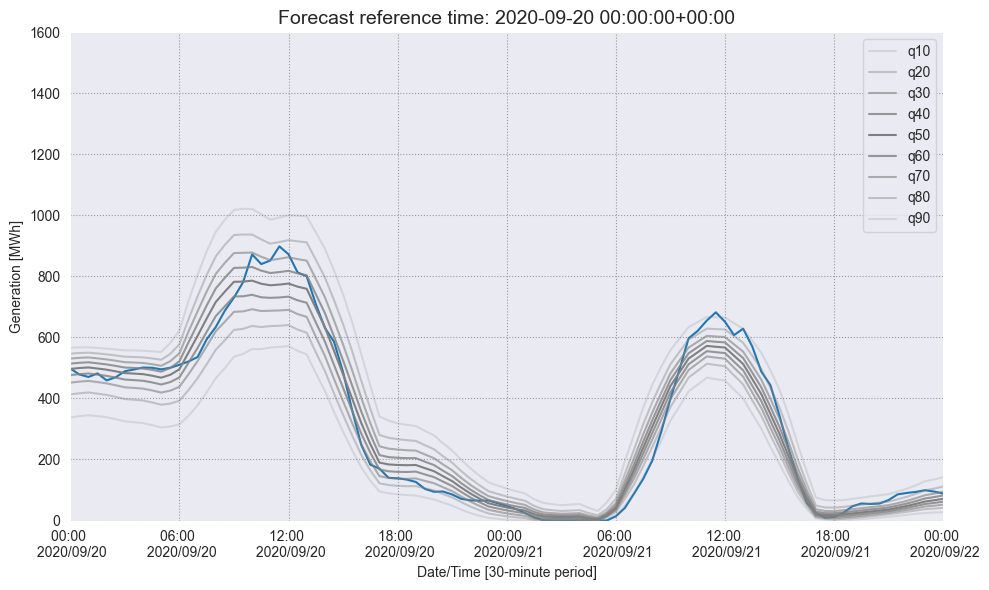

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# ref_datetimeの条件に一致する行を抽出
ref_time = modelling_table["ref_datetime"] == modelling_table["ref_datetime"][10]
filtered_data = modelling_table[ref_time]

plt.figure(figsize=(10, 6))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
ax1 = sns.lineplot(data=filtered_data, x="valid_datetime", y="total_generation_MWh")

for quantile in range(10, 100, 10):
    sns.lineplot(data=modelling_table,
                 x=filtered_data["valid_datetime"],
                 y=filtered_data[f"q{quantile}"],
                 color='gray',
                 alpha=1 - abs(50 - quantile) / 50,
                 label=f'q{quantile}')

plt.ylim(0, 1600)
plt.xlim(filtered_data['valid_datetime'].min(), filtered_data['valid_datetime'].max())
#plt.xticks(modelling_table['valid_datetime'][::6])
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M \n %Y/%m/%d"))
plt.xlabel('Date/Time [30-minute period]')
plt.ylabel('Generation [MWh]')
plt.title(f"Forecast reference time: {filtered_data['ref_datetime'].iloc[0]}", fontsize=14)
plt.tight_layout()

plt.show()

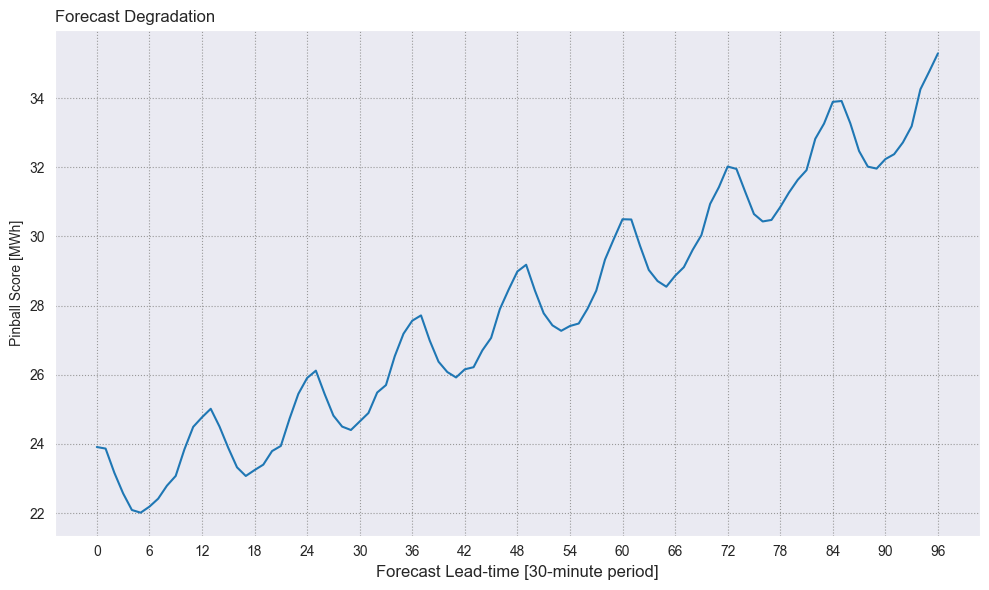

In [21]:
import matplotlib.ticker as ticker

modelling_table['lead_time'] = modelling_table['valid_datetime'] - modelling_table['ref_datetime']

forecast_performance = modelling_table.groupby('lead_time').apply(pinball_score)
forecast_performance = modelling_table.groupby('lead_time').apply(pinball_score)
forecast_performance.index = forecast_performance.index.total_seconds() / (1800)

plt.figure(figsize=(10, 6))
ax1 = forecast_performance.plot()
ax1.set_ylabel('Pinball Score [MWh]')
ax1.set_xlabel('Forecast Lead-time [30-minute period]', fontsize=12)

# x軸の刻みを変更
ax1.xaxis.set_major_locator(ticker.MultipleLocator(base=6))  # 6は3時間ごとに調整したい場合

ax1.set_title('Forecast Degradation', loc='left')
plt.tight_layout()

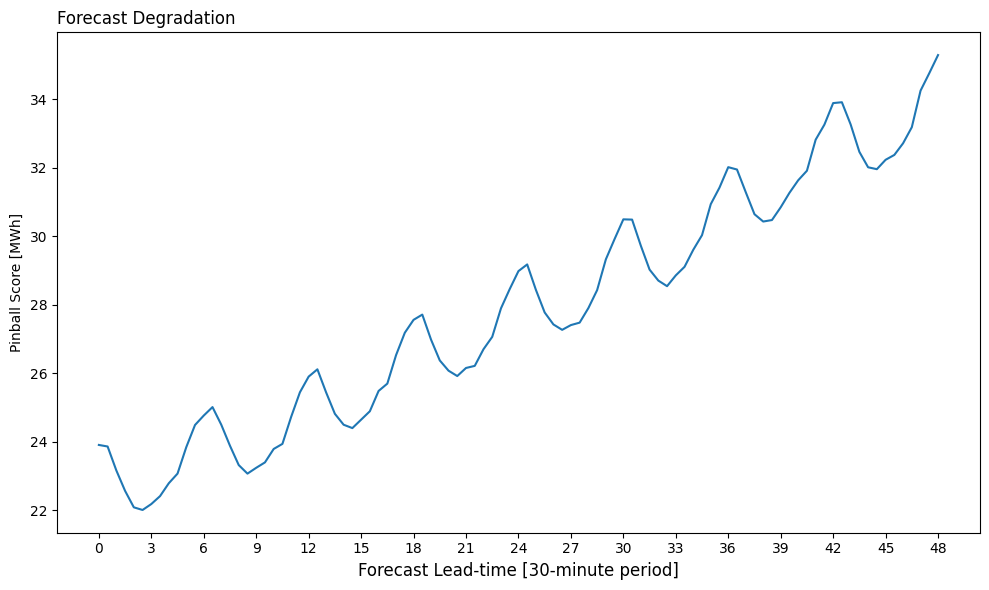

In [9]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

modelling_table['lead_time'] = modelling_table['valid_datetime'] - modelling_table['ref_datetime']

forecast_performance = modelling_table.groupby('lead_time').apply(pinball_score)
forecast_performance = modelling_table.groupby('lead_time').apply(pinball_score)
forecast_performance.index = forecast_performance.index.total_seconds() / (3600)

plt.figure(figsize=(10, 6))
ax1 = forecast_performance.plot()
ax1.set_ylabel('Pinball Score [MWh]')
ax1.set_xlabel('Forecast Lead-time [30-minute period]', fontsize=12)

# x軸の刻みを変更
ax1.xaxis.set_major_locator(ticker.MultipleLocator(base=3))  # 6は3時間ごとに調整したい場合

ax1.set_title('Forecast Degradation', loc='left')
plt.tight_layout()

In [5]:
forecast_performance

lead_time
0.0     23.908271
1.0     23.863007
2.0     23.163486
3.0     22.567316
4.0     22.087047
          ...    
92.0    32.715636
93.0    33.185340
94.0    34.253091
95.0    34.763287
96.0    35.291304
Length: 97, dtype: float64